# Playing around with the data to get a better understanding

RADAR is FMCW

In [0]:
%matplotlib inline

In [2]:
import os
if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
#     os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif os.getcwd() == 'D:\\Google Drive\\Level-4-Project\\notebooks\\data_processing' or os.getcwd() == 'D:\\Google Drive\\Level-4-Project\\src\\features':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
else:
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/'
RAW_PATH = DATA_PATH + 'raw/raw_converted/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Running setup.py develop for src


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from scipy.signal import butter, freqz, lfilter, spectrogram

In [0]:
# Load in file to pandas dataframe
df = pd.read_csv(RAW_PATH + "Dataset_97.dat", header=None)[1]

In [0]:
# Grab RADAR settings from top of file
center_frequency = float(df.iloc[1])
sweep_time = float(df.iloc[2])/1000  # convert to seconds
number_of_time_samples = float(df.iloc[3])
bandwidth = float(df.iloc[4])
sampling_frequency = number_of_time_samples/sweep_time
record_length = 60
number_of_chirps = record_length/sweep_time

In [6]:
print(sweep_time)

0.001


In [0]:
# Put data values into an array
data = df.iloc[5:].apply(complex).values

In [0]:
# Reshape into chirps over time
data_time = np.reshape(data, (int(number_of_chirps),int(number_of_time_samples)))
data_time = np.rot90(data_time, k=-1)

Text(0.5,1,'60 seconds')

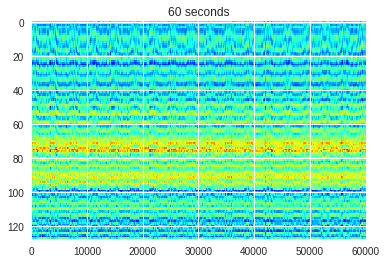

In [9]:
plt.imshow(abs(data_time),cmap='jet', aspect="auto")
plt.title("60 seconds")

Text(0.5,1,'3 seconds')

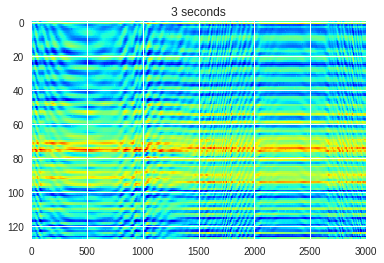

In [10]:
plt.imshow(abs(data_time)[:,:3000],cmap='jet', aspect="auto")
plt.title("3 seconds")

Text(0.5,1,'1 second')

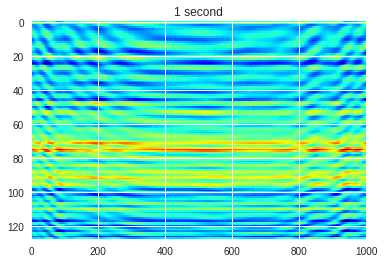

In [11]:
plt.imshow(abs(data_time)[:,:1000],cmap='jet', aspect="auto")
plt.title("1 second")

In [0]:
win = np.ones((int(number_of_time_samples), data_time.shape[1]))
win = np.ones(data_time.shape)

In [0]:
# Apply fast fourier transform should compute distance (range) from objects
fft_applied = np.fft.fft((data_time * win), axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Range FFT')

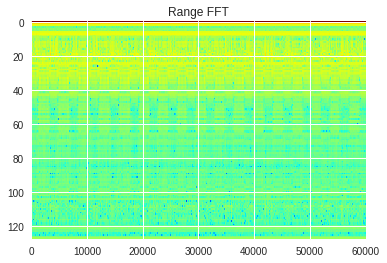

In [14]:
plt.imshow(20*(np.log10(abs(fft_applied))),cmap='jet', aspect="auto")
plt.title("Range FFT")

In [0]:
data_range = fft_applied[:int(number_of_time_samples/2), :] # take half for some reason?

Text(0.5,1,'Half of Range FFT')

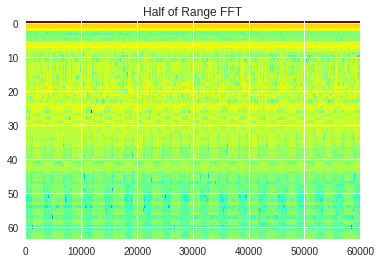

In [0]:
plt.imshow(20*(np.log10(abs(data_range))),cmap='jet', aspect="auto")
plt.title("Half of Range FFT")

In [0]:
def nearest_odd_number(x):
    if(np.floor(x) % 2 == 0):
        return int(np.floor(x) + 1)
    else:
        return int(np.floor(x))

 Moving Target Indicator (MTI) Filter :
*  suppress echoes from clutter
 * property of clutter is that it is stationary or close to stationary,
*  the Doppler frequencies induced by echoes from clutter is zero or close to zero. 
*  The MTI filter is a high pass filter that filters out the low Doppler frequencies,

In [0]:
# IIR Notch filter
x = data_range.shape[1]
ns = nearest_odd_number(x) - 1

In [0]:
data_range_MTI = np.zeros((data_range.shape[0], ns), dtype=np.complex128)

In [0]:
(b, a) = butter(4, 0.01, btype="high") # make a filter "remove DC component?" and very low frequency components?

In [0]:
# Apply Filter
for i in range(data_range.shape[0]):
    data_range_MTI[i, :ns] = lfilter(b, a, data_range[i, :ns], axis=0)

Text(0.5,1,'Filter Applied')

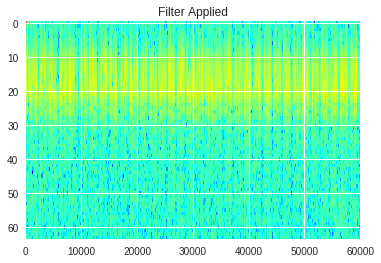

In [0]:
plt.imshow(20*(np.log10(abs(data_range_MTI))),cmap='jet', aspect="auto")
plt.title("Filter Applied")

In [0]:
# Remove first range bin as has strong residual possibly from filtering?
data_range_MTI = data_range_MTI[1:, :]

Text(0.5,1,'First Range Bin Removed')

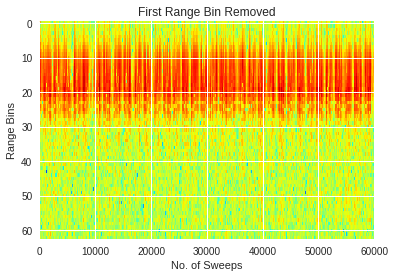

In [0]:
plt.xlabel("No. of Sweeps")
plt.ylabel("Range Bins")
plt.imshow(20 * np.log10(abs(data_range_MTI)),cmap='jet', aspect="auto")
plt.title("First Range Bin Removed")

Spectrogram processing for 2nd FFT to get Doppler

In [0]:
# Selects range bins
bin_indl = 5
bin_indu = 25

prf = 1/sweep_time
time_window_length = 200
overlap_factor = 0.95
overlap_length = np.round(time_window_length * overlap_factor)
pad_factor = 4
fft_points = pad_factor * time_window_length
doppler_bin = prf / fft_points
doppler_axis = np.arange(-prf / 2, prf / 2 - doppler_bin + 1, doppler_bin)
whole_duration = data_range_MTI.shape[1] / prf
num_segments = np.floor((data_range_MTI.shape[1] - time_window_length) /
    (np.floor(time_window_length * (1 - overlap_factor))))

In [0]:
data_spec_MTI2=0
for rbin in range(bin_indl-1, bin_indu):    
    s, f, t = mlab.specgram(data_range_MTI[rbin, :],
                            Fs=1,
                            window=np.hamming(time_window_length),
                            noverlap=overlap_length,
                            NFFT=time_window_length, 
                            mode='complex',
                            pad_to=fft_points )
    
    data_MTI_temp = np.fft.fftshift(s, 1)
    data_spec_MTI2=data_spec_MTI2+abs(data_MTI_temp);                                


In [0]:
time_axis = np.linspace(0, whole_duration, data_spec_MTI2.shape[1])

Text(0.5,1,'Doppler FFT')

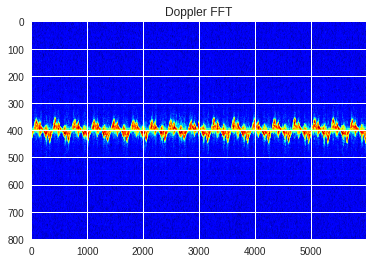

In [0]:
plt.imshow(20 * np.log10(abs(data_spec_MTI2)),cmap='jet', aspect="auto")
plt.title("Doppler FFT")

Text(0,0.5,'Doppler [Hz]')

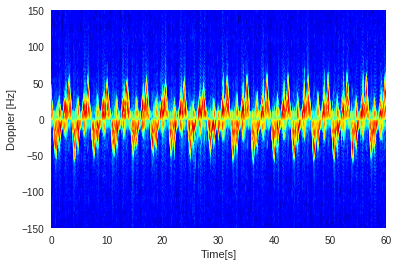

In [0]:
plt.pcolormesh(time_axis, doppler_axis, 20 * np.log10(np.abs(data_spec_MTI2)),cmap='jet')
plt.ylim([-150, 150])
plt.xlabel("Time[s]")
plt.ylabel("Doppler [Hz]")

In [0]:
import time

In [0]:
from matplotlib import colors
image_width = 150
image_height = 150
minimum_value = 35
norm = colors.Normalize(vmin=minimum_value, vmax=None, clip=True)


In [0]:
    window_size = 300  # 3 seconds
    iterations = data_spec_MTI2.shape[1] - window_size
    step_size = 10  # 0.1 seconds
    for i in range(0, iterations, step_size):
        start_time = time.time()
        center = int(data_spec_MTI2.shape[0]/2)
        data_spec_small = data_spec_MTI2[(center-150):(center+150), i:(i + window_size)]
        w = 150
        h = 150
    
        fig = plt.figure(frameon=False)
        fig.set_size_inches(w,h)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        ax.imshow(20 * np.log10(abs(data_spec_small)), cmap='jet', norm=norm, aspect="auto")
        fig.savefig("C:/Users/macka/Desktop/temp/" + str(i) + ".png", dpi=1)
        break
        time_for_row = (time.time() - start_time)/60
        print("\n--- %s minutes ---" % (time_for_row))
        